In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import cv2
from pathlib import Path
from PIL import Image
from scipy import ndimage, optimize
from scipy.fft import fft2, ifft2
from scipy.special import genlaguerre
from scipy.optimize import nnls
from scipy.special import factorial
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d



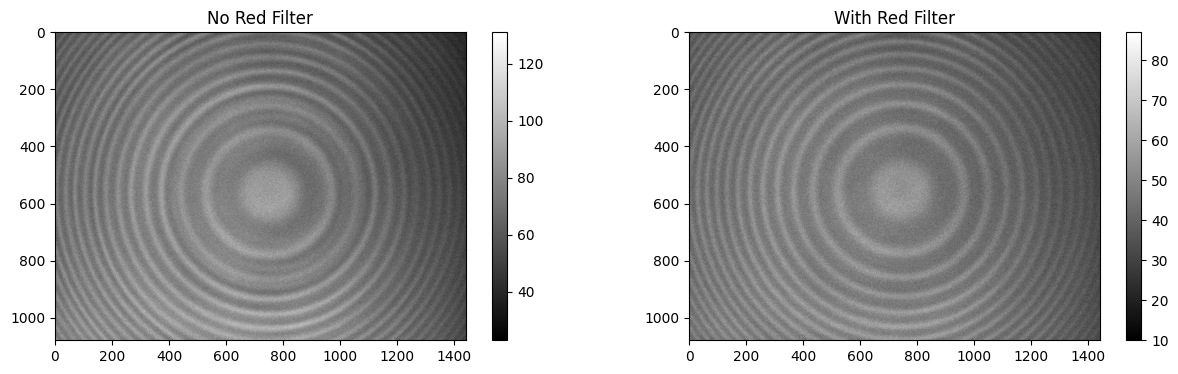

In [4]:
img_nored = Image.open('noredfilter.png').convert('L')
arr_nored = np.array(img_nored).astype(float)

img_red = Image.open('redfilter.png').convert('L')
arr_red = np.array(img_red).astype(float)

fig, (ax_nored, ax_red) = plt.subplots(1, 2, figsize=(15, 4))

nored = ax_nored.imshow(arr_nored, cmap='gray')
ax_nored.set_title("No Red Filter")
fig.colorbar(nored, ax=ax_nored)


red = ax_red.imshow(arr_red, cmap='gray')
ax_red.set_title("With Red Filter")
fig.colorbar(red, ax=ax_red)

plt.show()

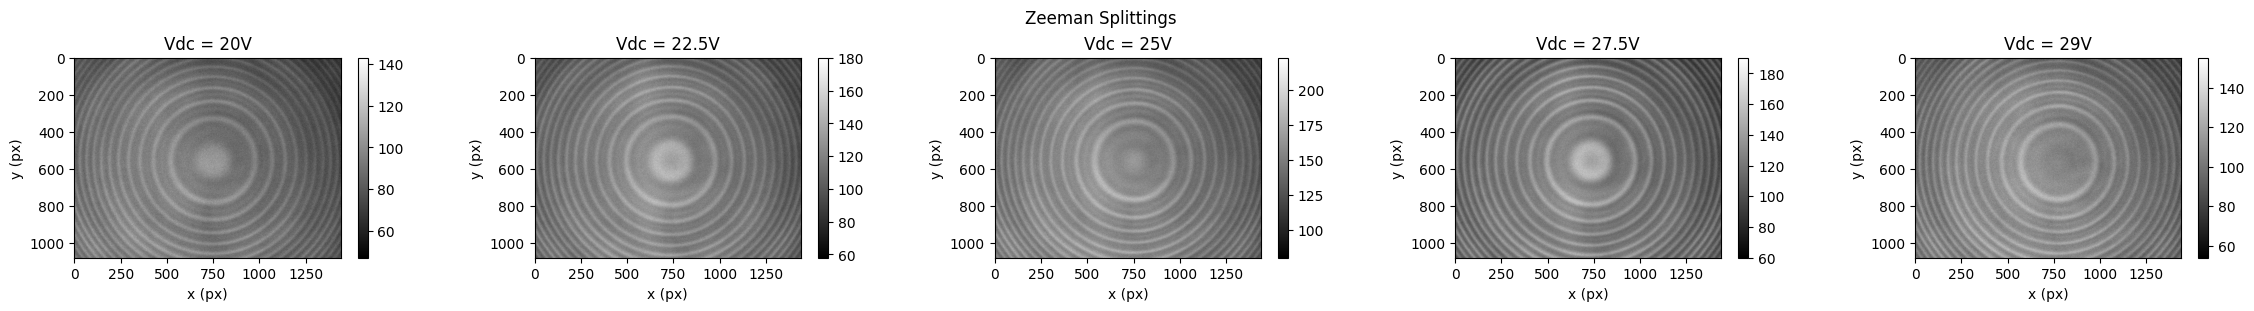

In [15]:
vdc_vals = np.array([int(20), 22.5, 25, 27.5, 29])

img_20 = Image.open(f'vdc_20_splitting_measurements.png').convert('L')
arr_20 = np.array(img_20).astype(float)  

img_225 = Image.open(f'vdc_22.5_splitting_measurements.png').convert('L')
arr_225 = np.array(img_225).astype(float)  

img_25 = Image.open(f'vdc_25_splitting_measurements.png').convert('L')
arr_25 = np.array(img_25).astype(float)  

img_275 = Image.open(f'vdc_27.5_splitting_measurements.png').convert('L')
arr_275 = np.array(img_275).astype(float)  

img_29 = Image.open(f'vdc_29_splitting_measurements.png').convert('L')
arr_29 = np.array(img_29).astype(float)  


fig_splitting, axs_splitting = plt.subplots(
    1, 5, num='Splitting Measurement', figsize=(23, 3), clear=True, constrained_layout=True)


for (ax, im_, im_cmap, label, cmap) in zip(
        axs_splitting,
        [img_20, img_225, img_25, img_275, img_29],
        [img_20, img_225, img_25, img_275, img_29],
        ['Vdc = 20V', 'Vdc = 22.5V', 'Vdc = 25V', 'Vdc = 27.5V', 'Vdc = 29V'],
        ['gray', 'gray', 'gray', 'gray', 'gray']
        ):

    h_im = ax.imshow(
        im_,
        cmap=cmap
        # vmin=im_cmap.min() if im_cmap is not None else None,
        # vmax=im_cmap.max() if im_cmap is not None else None,
        )
    ax.set_ylabel('y (px)')
    ax.set_xlabel('x (px)')
    h_cbar = plt.colorbar(h_im, ax=ax)
    ax.set_title(label)

fig_splitting.suptitle('Zeeman Splittings')

plt.show()

# Image Processing

In [26]:
def remove_background_poly2(img):
    """
    Fit and subtract 2D quadratic background.
    """
    img = img.astype(float)
    ny, nx = img.shape
    y, x = np.indices(img.shape)

    X = np.column_stack([
        np.ones(img.size),
        x.ravel(),
        y.ravel(),
        x.ravel()**2,
        y.ravel()**2,
        x.ravel()*y.ravel()
    ])

    coeffs, *_ = np.linalg.lstsq(X, img.ravel(), rcond=None)
    background = (X @ coeffs).reshape(img.shape)

    corrected = img - background
    corrected -= corrected.min()

    return corrected, background


In [35]:
def centroid_from_core(img, blur_sigma=2.0, top_frac=0.05):
    """
    Find center by centroiding only the brightest 'core' pixels.
    top_frac=0.05 means keep the top 5% brightest pixels (after blur).
    Returns (xc, yc).
    """
    I = img.astype(float)
    I_s = gaussian_filter(I, blur_sigma)

    # threshold at a high percentile to isolate the core
    thr = np.quantile(I_s, 1.0 - top_frac)
    mask = I_s >= thr

    y, x = np.indices(I.shape)
    w = I_s * mask  # weight only within mask

    if w.sum() <= 0:
        raise ValueError("Core mask is empty; try increasing top_frac or reducing blur_sigma.")

    xc = (x * w).sum() / w.sum()
    yc = (y * w).sum() / w.sum()
    return xc, yc




def refine_center_by_ring_symmetry(
    img,
    x0, y0,
    search_radius=30,      # pixels to search around initial guess
    step=1,                # grid step (1 px is usually fine)
    blur_sigma=1.5,
    r_min=20, r_max=None,  # use rings region; avoid very center
    nr=200, ntheta=180
):
    """
    Pick center that minimizes angular variance of intensity as a function of radius.
    Returns refined (xc, yc).
    """
    I = gaussian_filter(img.astype(float), blur_sigma)
    ny, nx = I.shape
    if r_max is None:
        r_max = min(nx, ny) * 0.45

    # Precompute pixel coordinates once
    yy, xx = np.indices(I.shape)

    best = None
    best_score = np.inf

    xs = np.arange(x0 - search_radius, x0 + search_radius + 1, step)
    ys = np.arange(y0 - search_radius, y0 + search_radius + 1, step)

    for xc in xs:
        for yc in ys:
            r = np.sqrt((xx - xc)**2 + (yy - yc)**2)
            th = np.arctan2(yy - yc, xx - xc)

            # restrict to annulus where rings live
            m = (r >= r_min) & (r <= r_max)
            if m.sum() < 1000:
                continue

            r_m = r[m].ravel()
            th_m = th[m].ravel()
            I_m = I[m].ravel()

            # bin into (r, theta)
            r_edges = np.linspace(r_min, r_max, nr + 1)
            th_edges = np.linspace(-np.pi, np.pi, ntheta + 1)

            # mean intensity per (r,theta) bin
            stat, _, _, _ = binned_statistic_2d(r_m, th_m, I_m, statistic="mean",
                                                bins=[r_edges, th_edges])
            # For each radius bin, compute angular std dev (ignore NaNs)
            ang_std = np.nanstd(stat, axis=1)

            # Score: average angular std dev across radii
            score = np.nanmean(ang_std)

            if np.isfinite(score) and score < best_score:
                best_score = score
                best = (xc, yc)

    if best is None:
        raise ValueError("Refinement failed; try increasing search_radius or adjusting r_min/r_max.")

    return best




def radial_profile_centered(img, nbins=1500, plot=True):
    img = img.astype(float)

    # 1) robust initial center from core
    x0, y0 = centroid_from_core(img, blur_sigma=2.0, top_frac=0.03)

    # 2) refine using ring symmetry
    xc, yc = refine_center_by_ring_symmetry(
        img, x0, y0,
        search_radius=40, step=1,
        r_min=30, r_max=None
    )

    # 3) radial average around refined center
    ny, nx = img.shape
    y, x = np.indices((ny, nx))
    r = np.sqrt((x - xc)**2 + (y - yc)**2).ravel()
    I = img.ravel()

    radial_mean, edges, _ = binned_statistic(r, I, statistic="mean", bins=nbins)
    r_centers = 0.5 * (edges[1:] + edges[:-1])

    if plot:
        plt.figure()
        plt.plot(r_centers, radial_mean)
        plt.xlabel("Radius (pixels)")
        plt.ylabel("Mean intensity")
        plt.title(f"Radial profile (center=({xc:.2f},{yc:.2f}))")
        plt.tight_layout()
        plt.show()

    return r_centers, radial_mean, (xc, yc)


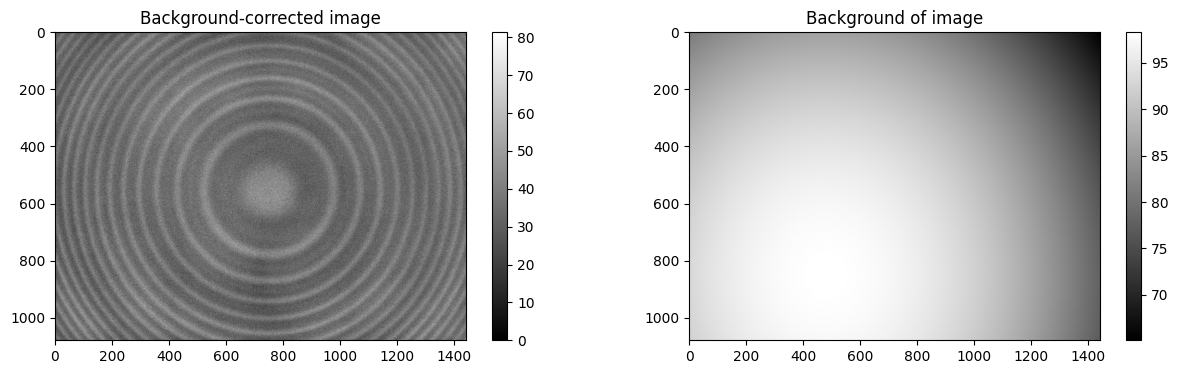

In [ ]:
img_20_corr, img_20_corr_bkg = remove_background_poly2(arr_20)


fig, (ax_corr, ax_bkg) = plt.subplots(1, 2, figsize=(15, 4))

corr = ax_corr.imshow(img_20_corr, cmap='gray')
ax_corr.set_title('Background-corrected image')
fig.colorbar(corr, ax=ax_corr)

bkg = ax_bkg.imshow(img_20_corr_bkg, cmap='gray')
ax_bkg.set_title('Background of image')
fig.colorbar(bkg, ax=ax_bkg)

plt.show()



r, I_r, center = radial_profile_centered(img_20_corr, nbins=2000)

print("Centroid:", center)


h = plt.imshow(img_20_corr, cmap='gray')
plt.scatter(center[0], center[1], label='center')
plt.legend()
plt.colorbar(h)

plt.show()